In [1]:
%reset -f
import numpy as np
import pandas as pd
import random
import math
import os
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# Data load

In [2]:
mat = scipy.io.loadmat('NASAtrain_filtered.mat') #reads dataset for ICA
#mat = scipy.io.loadmat('NASAtrain_ICA_part.mat') #reads dataset for ICA
#mat = scipy.io.loadmat('NASAtrain_V.mat') #reads dataset for V segments
#mat = scipy.io.loadmat('NASAtrain_I.mat') #reads dataset for I segments
cellsName = [keys for keys in mat.keys() if not keys.startswith('__')]
numCell = len(cellsName)
print("mat structure:", numCell)
print("Name of cells:", cellsName)

mat structure: 4
Name of cells: ['train1', 'train2', 'train3', 'train4']


In [3]:
range(numCell)

range(0, 4)

In [4]:
# Extract data from matalab to list in python
Sequences = []
Labels = []
Length_ICA = []
windows = 0

for i in range(numCell):
    mat[cellsName[i]][0][0].dtype.names
    mat[cellsName[i]][0][0]['data'][0][0].shape
    numCycle = len(mat[cellsName[i]][0][0]['data'])
    numCycle

    sequences = [[] for _ in range(numCycle)]
    label = [[] for _ in range(numCycle)]
    length = [[] for _ in range(numCycle)]

    for j in range(numCycle):
      sequences[j] =  torch.tensor(mat[cellsName[i]][0][0]['data'][j][0]).float() # list contain tensor sequences
      label[j] = torch.tensor(mat[cellsName[i]][0][0]['label'][j][0]).float()
      length[j] = len(mat[cellsName[i]][0][0]['data'][j][0][0])
      #print(f"size of ICA curves: {len(sequences)}")
    Sequences.extend(sequences)
    Labels.extend(label)
# The dataset include the packed datas(size = windows) in format of list
# All datas are already the tensor format
print(f"size of Data Sequences(s): {len(Sequences)} and labels: {len(Labels)}")
print(f"Typical shape of Dataset: {sequences[1].shape}")


size of Data Sequences(s): 636 and labels: 636
Typical shape of Dataset: torch.Size([3, 127])


torch.Size([3, 99])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 98])
torch.Size([3, 97])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 95])
torch.Size([3, 96])
torch.Size([3, 98])
torch.Size([3, 94])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 98])
torch.Size([3, 97])
torch.Size([3, 95])
torch.Size([3, 95])
torch.Size([3, 95])
torch.Size([3, 98])
torch.Size([3, 97])
torch.Size([3, 95])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 124])
torch.Size([3, 124])
torch.Size([3, 123])
torch.Size([3, 123])
torch.Size([3, 124])
torch.Size([3, 123])
torch.Size([3, 122])
torch.Size([3, 123])
torch.Size([3, 124])
torch.Size([3, 125])
torch.Size([3, 124])
torch.Size([3, 124])
torch.Size([3, 98])
torch.Size([3, 124])
torch.Size([3, 124])
torch.Size([3, 125])
torch.Size([3, 125])
torch.Size([3, 123])
torch.Size([3, 123])
to

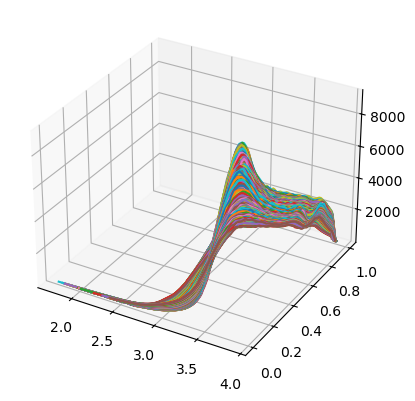

In [5]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(len(Sequences)):
  print(Sequences[i].shape)
  ax.plot(np.array(Sequences[i][0]), np.array(Sequences[i][1]), np.array(Sequences[i][2]), label='ICA')  

# Model define

In [6]:
# Helper function to partition data
def trainingPartitions_3(numObservations, ratios):
    indices = np.arange(numObservations)
    np.random.shuffle(indices)
    train_end = int(ratios[0] * numObservations)
    val_end = train_end + int(ratios[1] * numObservations)
    return indices[:train_end], indices[train_end:val_end], indices[val_end:]

def trainingPartitions(numObservations, ratios):
    indices = np.arange(numObservations)
    np.random.shuffle(indices)
    train_end = int(ratios[0] * numObservations)
    return indices[:train_end], indices[train_end:]
       
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn_trim(batch):
    data_points, targets = zip(*batch)
    min_length = min(len(item[1]) for item in data_points)
    trimmed_sequences = [seq[:, :min_length] for seq in data_points]
    
    return trimmed_sequences, torch.tensor(targets)
    
    

numObservations = len(Sequences)
idxTrain, idxTest = trainingPartitions(numObservations, [0.9, 0.2])

XTrain = [Sequences[i] for i in idxTrain]
XTest = [Sequences[i] for i in idxTest]

TTrain = [Labels[i] for i in idxTrain]
TTest = [Labels[i] for i in idxTest]

print(f"Size of \n Train: {len(XTrain)} \n Test: {len(XTest)}")
print("--------------------------------------------------")
train_dataset = SequenceDataset(XTrain, TTrain)
test_dataset = SequenceDataset(XTest, TTest)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn_trim)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn_trim)


print(f"batch num of train_loader: {len(train_loader)} \nbatch num of test_loader: {len(test_loader)}")
print("--------------------------------------------------")
X_batch, T_batch= next(iter(test_loader))
print("Example size of dataloader display:")
for i in range(len(X_batch)):
    print(f"{i+1}: \t{X_batch[i].shape} \t{T_batch[i]}" )

#for i in X_batch:
    #print(i.shape)


Size of 
 Train: 445 
 Test: 191
--------------------------------------------------
batch num of train_loader: 2 
batch num of test_loader: 1
--------------------------------------------------
Example size of dataloader display:
1: 	torch.Size([3, 94]) 	0.7207786440849304
2: 	torch.Size([3, 94]) 	0.6275774240493774
3: 	torch.Size([3, 94]) 	0.841499388217926
4: 	torch.Size([3, 94]) 	0.7271508574485779
5: 	torch.Size([3, 94]) 	0.7143441438674927
6: 	torch.Size([3, 94]) 	0.9592509269714355
7: 	torch.Size([3, 94]) 	0.9563341736793518
8: 	torch.Size([3, 94]) 	0.9618955850601196
9: 	torch.Size([3, 94]) 	0.9131274819374084
10: 	torch.Size([3, 94]) 	0.9772529006004333
11: 	torch.Size([3, 94]) 	0.9325271248817444
12: 	torch.Size([3, 94]) 	0.7996575832366943
13: 	torch.Size([3, 94]) 	0.905669629573822
14: 	torch.Size([3, 94]) 	0.850996732711792
15: 	torch.Size([3, 94]) 	0.756859302520752
16: 	torch.Size([3, 94]) 	0.7133058309555054
17: 	torch.Size([3, 94]) 	0.6913794279098511
18: 	torch.Size([3,

In [7]:
# Position Embedding Layer
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# Transformer-based CNN-LSTM Model with attention mechanism
class CNN_LSTM(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)
        
        # Apply self-attention
        x = x.transpose(0, 1)  # Convert to (seq_length, batch, channels)
        x, attn_weights = self.self_attention(x, x, x)
        x = x.transpose(0, 1)  # Convert to (batch, seq_length, channels)
        
        # Select top 32 features based on attention weights
        attn_weights = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights.topk(10, dim=1, largest=True).indices
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x = x[batch_indices, topk_indices]

        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
        x = self.relu(x)
        x = x.reshape(x.size(0), -1, 32)  # (batch, new_seq_length, channels)
        # Directly pass the sequence to LSTM
        x, (hn, cn) = self.lstm(x)
        hn = self.dropout(hn)
        x = self.fc1(hn[-1])
        x = self.relu(x)
        x = self.fc2(x)
        return x

## CNN_Att_LSTM main define

In [8]:
topelement = 32

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class CNN_LSTM_position(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM_position, self).__init__()
        # Single CNN layer
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.positional_encoding = PositionalEncoding(32)
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        # Apply the single CNN layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)

        # Apply self-attention
        x = x.transpose(0, 1)  # Convert to (seq_length, batch, channels)      
        x, attn_weights = self.self_attention(x, x, x)
        x = x.transpose(0, 1)  # Convert to (batch, seq_length, channels)

        # Add positional encoding
        x = self.positional_encoding(x)              
        # Select top features based on attention weights
        attn_weights = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights.topk(topelement, dim=1, largest=True).indices  # Top 32 features
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x = x[batch_indices, topk_indices]      
        
        x = self.relu(x)
        x = x.reshape(x.size(0), -1, 32)  # (batch, new_seq_length, channels)
        
        # Directly pass the sequence to LSTM
        x, (hn, cn) = self.lstm(x)
        
        x = self.fc1(hn[-1])
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Example usage
# num_channels = number of input channels, e.g., 3 for RGB images
# num_heads = number of attention heads
# num_hidden_units = number of hidden units in LSTM

# Loss function
def RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat - y) ** 2))

def MAELoss(yhat, y):
    return torch.mean(torch.abs(yhat - y))

def Error(yhat, y):
    return yhat - y


In [9]:
class CNN_LSTM_position_skip(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM_position_skip, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        
        # Attention and Positional Encoding
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.positional_encoding = PositionalEncoding(32)
        
        # Layer Norm for Add & Norm structure
        self.norm1 = nn.LayerNorm(32)  # Apply LayerNorm over the last dimension (32)
        self.norm2 = nn.LayerNorm(num_hidden_units)  # Apply LayerNorm to LSTM output
        
        # LSTM layer
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        # Apply the single CNN layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)

        # # Add positional encoding
        # x = self.positional_encoding(x)

        # Apply self-attention
        x2, attn_weights = self.self_attention(x.transpose(0, 1), x.transpose(0, 1), x.transpose(0, 1))
        x2 = x2.transpose(0, 1)  # Convert back to (batch, seq_length, channels)
        
        x2 = self.positional_encoding(x2)
        # Select top 32 features based on attention weights
        attn_weights_mean = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights_mean.topk(32, dim=1, largest=True).indices  # Top 32 features
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x_selected = x2[batch_indices, topk_indices]+x[batch_indices, topk_indices]
        
        # Add & Norm (1): Adding selected features to the corresponding original features
        x = self.norm1(x_selected)

        # Pass through LSTM
        x, (hn, cn) = self.lstm(x)
        
        # Add & Norm (2) before feeding to fully connected layers
        hn = self.norm2(hn[-1])  # Apply normalization to the last hidden state
        
        # Fully connected layers
        x = self.fc1(hn)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Test loop define

In [10]:
def trainLoop(train_loader,test_loader,model,showflag):
    numChannels = XTrain[0].size(0)
    numHeads = 4
    numHiddenUnits = 256
    num_epochs = 300
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.L1Loss()
    #criterion = RMSELoss
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    
    train_losses = []
    test_losses_RMSE = []
    test_losses_MAE = []
    best_model_state = None
    lowest_train_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            #print(f"Before Batch {batch_idx} - Input shape:{type(inputs)} {len(inputs)}, {len(inputs[0])}, {inputs[0][0].shape} - targets shape: {len(targets)}")
            inputs = torch.stack(inputs, dim=0).to(device)
            targets= targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
    
        # Save the best model based on training loss
        if train_loss < lowest_train_loss:
            lowest_train_loss = train_loss
            best_model_state = model.state_dict()
    
        # Test the model after each epoch
        model.eval()
        test_loss_RMSE = 0.0
        test_loss_MAE = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = torch.stack(inputs, dim=0).to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss_RMSE = RMSELoss(outputs.squeeze(), targets)
                test_loss_RMSE += loss_RMSE.item()
                loss_MAE = MAELoss(outputs.squeeze(), targets)
                test_loss_MAE += loss_MAE.item()
        # RMSE
        test_loss_RMSE = test_loss_RMSE / len(test_loader)
        test_losses_RMSE.append(test_loss_RMSE)
        # MAE
        test_loss_MAE = test_loss_MAE / len(test_loader)
        test_losses_MAE.append(test_loss_MAE)
        

        if showflag==1 and (epoch+1)%100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
            print(f"Epoch [{epoch+1}/{num_epochs}], Test RMSE: {test_loss_RMSE:.4f}")
        # Adjust the learning rate based on the validation loss
        scheduler.step(test_loss_RMSE)
    
    # Save the best model to a file
    torch.save(best_model_state, 'best_model.pth')
    #print(f"Lowest train loss: {min(train_losses)}, lowest test loss: {min(test_losses)}")
    if showflag == 1:
        print(f"Using device: {device}")
        print(f"Lowest train MSE: {min(train_losses)}/n Lowest test RMSE: {min(test_losses_RMSE)}/n Lowest test MAE: {min(test_losses_MAE)}")
        # Plot the losses using RMSE
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), test_losses_RMSE, label='Test RMSE')
        plt.plot(range(1, num_epochs + 1), test_losses_MAE, label='Test MAE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        plt.title('Training and Test RMSE')
        plt.show()
   
    return min(train_losses), min(test_losses_RMSE), min(test_losses_MAE), best_model_state


In [11]:
def testRestult(model_test_in, model_state_in, mat_data):
    #model_test = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
    mat = mat_data
    model_teat = model_test_in
    model_test.load_state_dict(model_state_in)
    def collate_fn_trim(batch):
        data_points, targets = zip(*batch)
        min_length = min(len(item[1]) for item in data_points)
        trimmed_sequences = [seq[:, :min_length] for seq in data_points]
        
        return trimmed_sequences, torch.tensor(targets)
    mdic ={}
    plt.figure()
    for i in range(numCell):
        mat[cellsName[i]][0][0].dtype.names
        mat[cellsName[i]][0][0]['data'][0][0].shape
        numCycle = len(mat[cellsName[i]][0][0]['data'])
        
        sequences_validaiton = [[] for _ in range(numCycle)]
        label_validaiton = [[] for _ in range(numCycle)]
        length_validaiton = [[] for _ in range(numCycle)]
        
        for j in range(numCycle):
          sequences_validaiton[j] =  torch.tensor(mat[cellsName[i]][0][0]['data'][j][0]).float() # list contain tensor sequences
          label_validaiton[j] = torch.tensor(mat[cellsName[i]][0][0]['label'][j][0]).float()
          length_validaiton[j] = len(mat[cellsName[i]][0][0]['data'][j][0][0])
        
        test_validaiton_dataset = SequenceDataset(sequences_validaiton, label_validaiton)
        test_validaiton_loader = DataLoader(test_validaiton_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn_trim)
       
        model_test.eval()
        test_loss_RMSE = 0.0
        test_loss_MAE = 0.0
        with torch.no_grad():
            for inputs, targets in test_validaiton_loader:
                inputs = torch.stack(inputs, dim=0).to(device)
                targets = targets.to(device)
                outputs = model_test(inputs)
                #print(f"{outputs} {targets}")
                loss_RMSE = RMSELoss(outputs.squeeze(), targets)
                test_loss_RMSE += loss_RMSE.item()
                loss_MAE = MAELoss(outputs.squeeze(), targets)
                test_loss_MAE += loss_MAE.item()
                #plt.plot(outputs.cpu(), targets.cpu(),'.')

        
        error = outputs.cpu().squeeze()-targets.cpu()
        error = torch.Tensor.numpy(error.cpu())
        outputs = torch.Tensor.numpy(outputs.squeeze().cpu())
        targets = torch.Tensor.numpy(targets.cpu())
        mdic.update({cellsName[i]: np.vstack((outputs, targets, error))})
        print(f"{test_loss_RMSE} {test_loss_MAE}")
        plt.subplot(1,2,1)
        plt.plot(outputs, targets,'.')
        plt.plot([0.6, 1], [0.6, 1],'-')
        
        plt.subplot(1,2,2)
        plt.plot(error)
    return mdic

Epoch [100/300], Train Loss: 0.0218
Epoch [100/300], Test RMSE: 0.0213
Epoch [200/300], Train Loss: 0.0135
Epoch [200/300], Test RMSE: 0.0236
Epoch [300/300], Train Loss: 0.0139
Epoch [300/300], Test RMSE: 0.0179
Using device: cuda
Lowest train MSE: 0.012245777528733015/n Lowest test RMSE: 0.016632650047540665/n Lowest test MAE: 0.013265522196888924


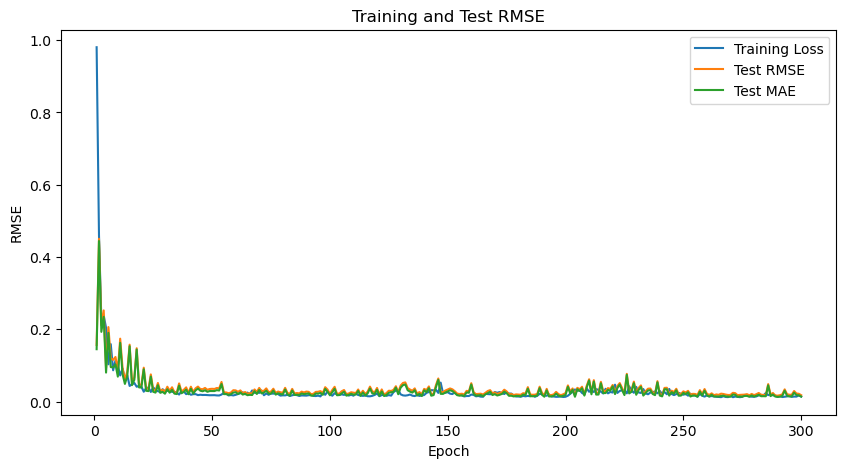

0.013473482802510262 0.010995740070939064
0.023274922743439674 0.01950232870876789
0.01818891428411007 0.01623702421784401
0.026808910071849823 0.022257236763834953



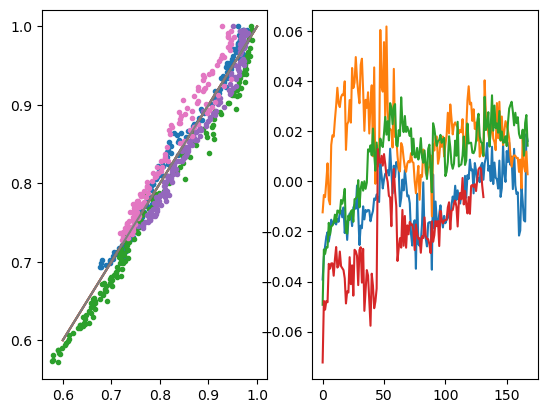

In [22]:
numChannels = XTrain[0].size(0)
numHeads = 4
numHiddenUnits = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
_,_,_,states=trainLoop(train_loader,test_loader,model,1)
model_test = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
results = testRestult(model_test, states, mat)
scipy.io.savemat('result.mat', results)
print()

CNN-LSTM
1 / 30 
0.012645324692130089 0.010090436786413193
0.022052636370062828 0.01380091905593872
0.018813541159033775 0.016370238736271858
0.04596669226884842 0.04050659015774727
2 / 30 
0.015027196146547794 0.012486284598708153
0.022854626178741455 0.015098858624696732
0.02258407697081566 0.020102793350815773
0.020632661879062653 0.01743260957300663
3 / 30 
0.01940748654305935 0.017066851258277893
0.017746414989233017 0.01380834449082613
0.010386032983660698 0.006875460501760244
0.047779448330402374 0.04245097562670708
4 / 30 
0.012871052138507366 0.010423697531223297
0.02106725610792637 0.012389012612402439
0.016776399686932564 0.013864097185432911
0.03026472218334675 0.02791251242160797
5 / 30 
0.01310631912201643 0.010798639617860317
0.02185945212841034 0.01553309801965952
0.01196337677538395 0.01033824123442173
0.03936608135700226 0.03311019390821457
6 / 30 
0.008946310728788376 0.006951956544071436
0.024112973362207413 0.01775517873466015
0.015467977151274681 0.013672541826963

C:\Users\Bob Gong\AppData\Local\Temp\ipykernel_7784\2856224223.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


22 / 30 
0.010693446733057499 0.008337598294019699
0.02353547513484955 0.015984071418642998
0.011512144468724728 0.009638596326112747
0.02213188447058201 0.0183890201151371
23 / 30 
0.018569644540548325 0.015433738939464092
0.021453987807035446 0.01708889752626419
0.010591411963105202 0.008591941557824612
0.0646628811955452 0.061984628438949585
24 / 30 
0.03788837790489197 0.03574215993285179
0.018943335860967636 0.016721004620194435
0.02856435440480709 0.024094710126519203
0.06586234271526337 0.060391586273908615
25 / 30 
0.019365085288882256 0.01643788069486618
0.016894971951842308 0.012384789995849133
0.01373360026627779 0.010599144734442234
0.060036953538656235 0.05622502416372299
26 / 30 
0.022783463820815086 0.021334229037165642
0.023201532661914825 0.019519733265042305
0.011081989854574203 0.007762205321341753
0.042095012962818146 0.037275899201631546
27 / 30 
0.019588766619563103 0.01635829359292984
0.016577772796154022 0.012072408571839333
0.015552574768662453 0.01303260959684

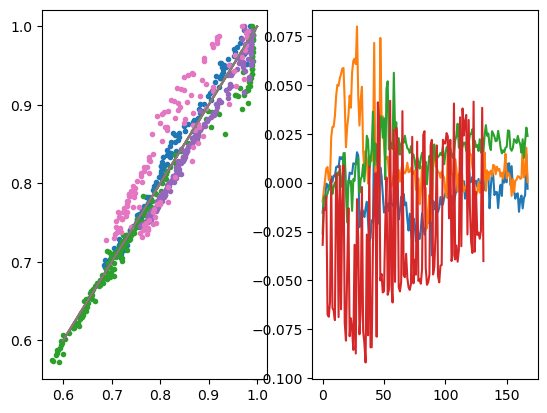

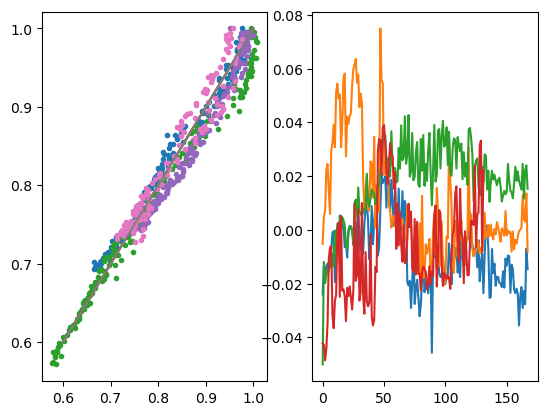

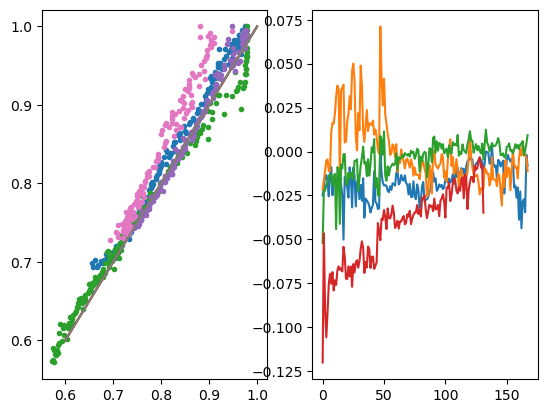

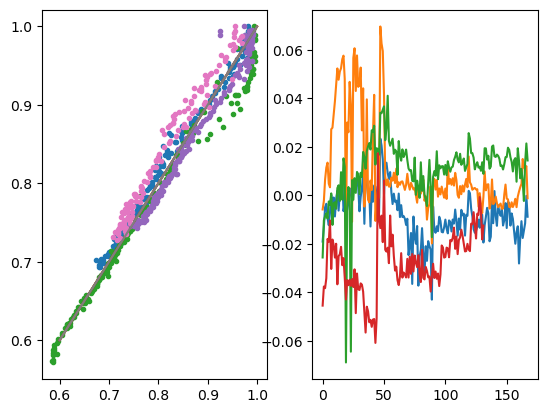

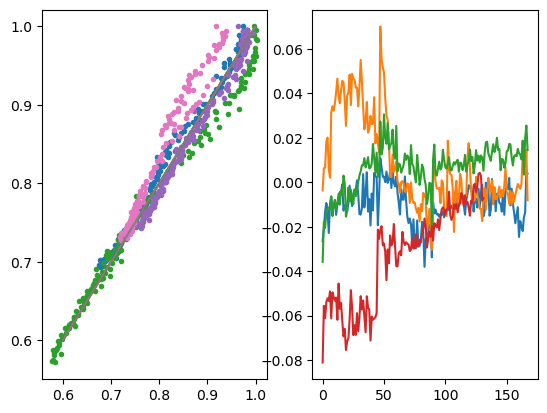

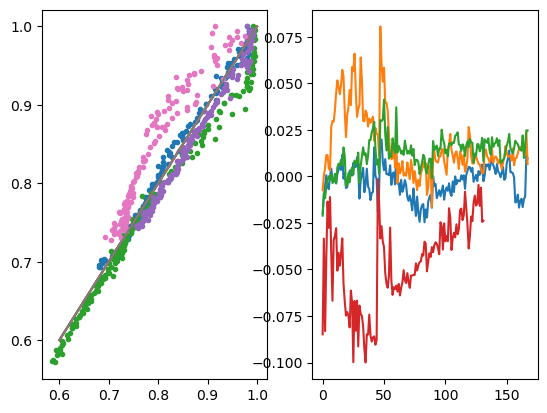

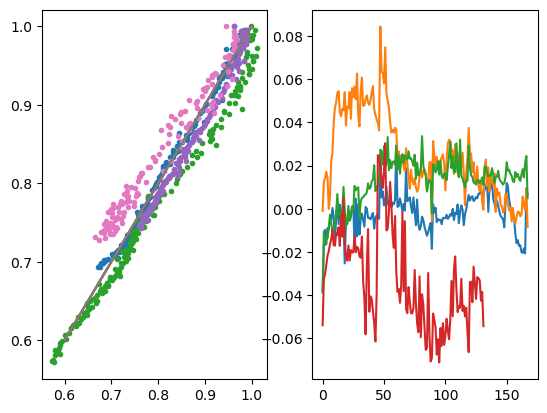

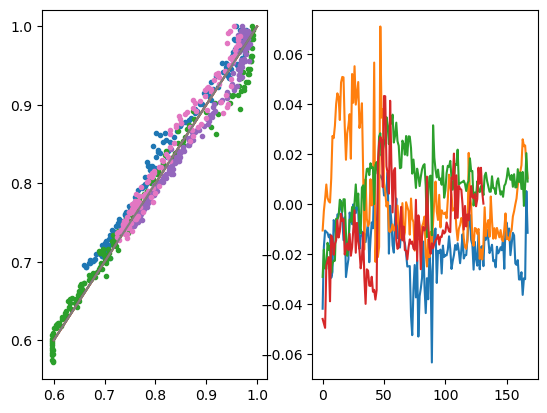

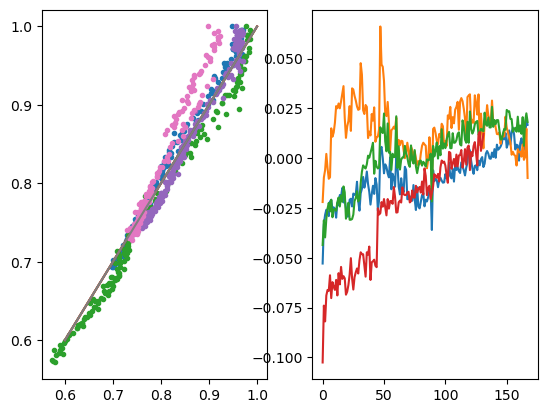

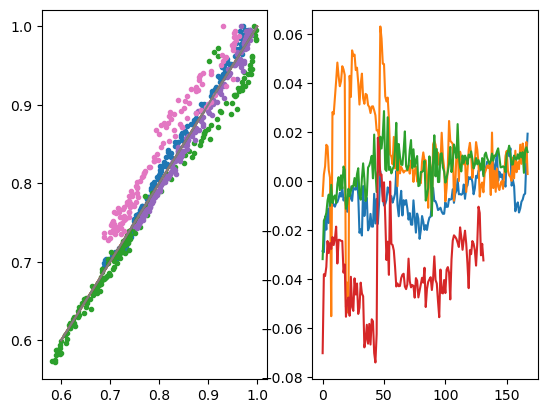

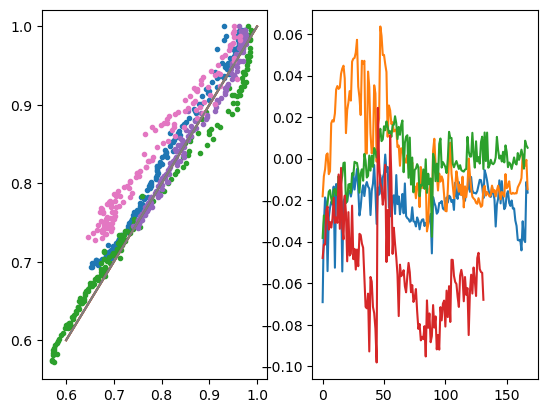

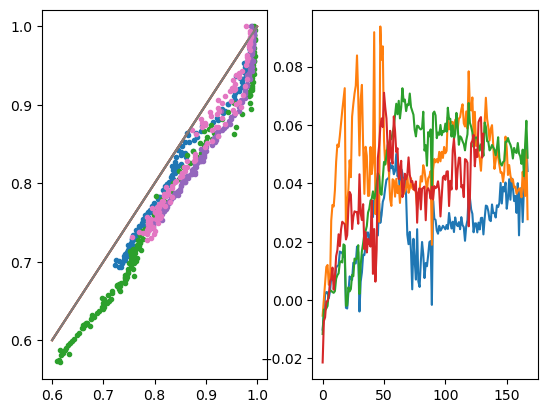

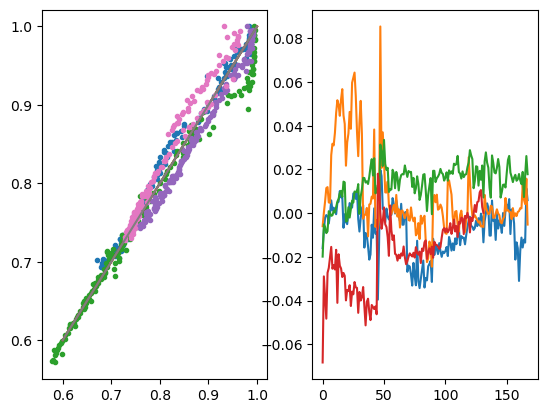

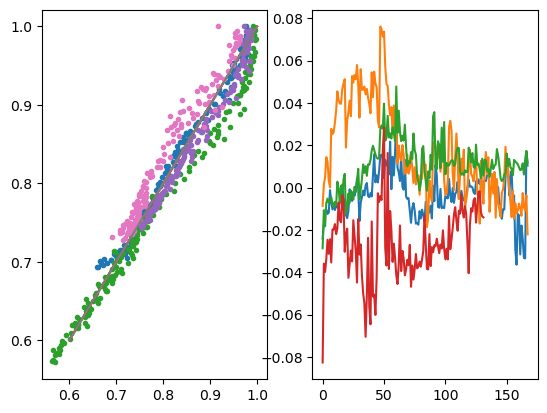

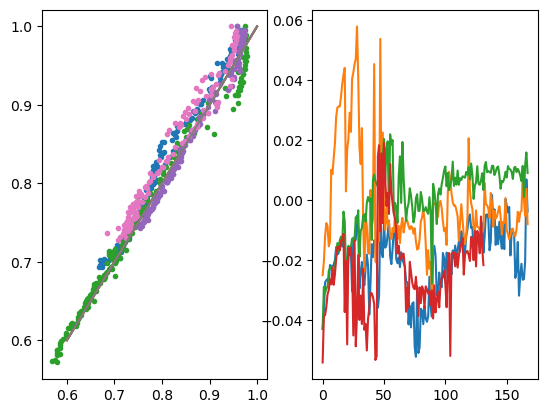

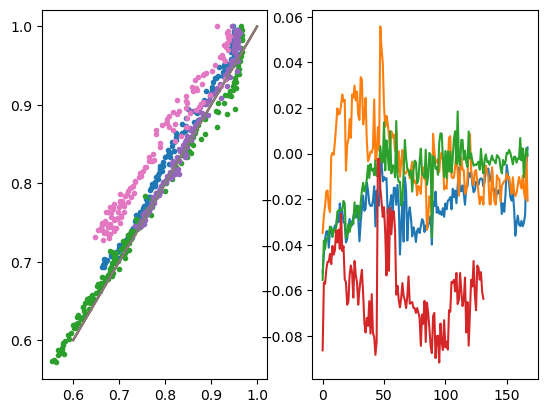

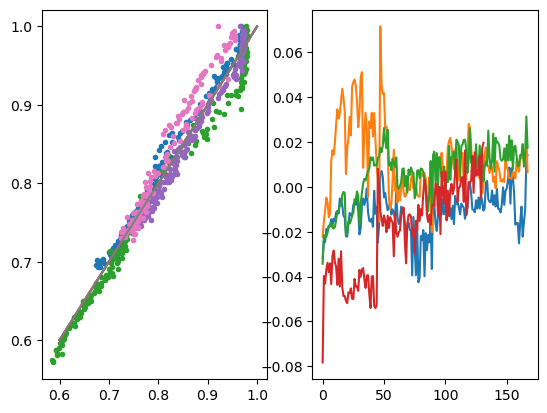

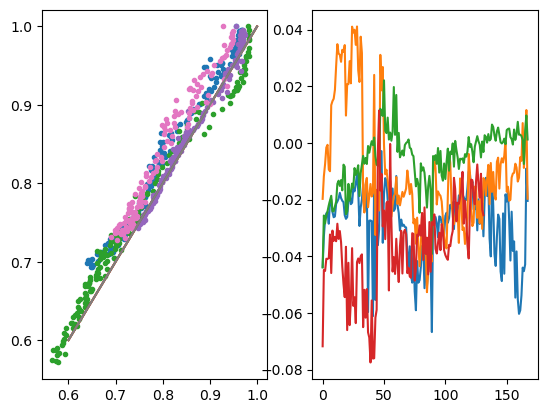

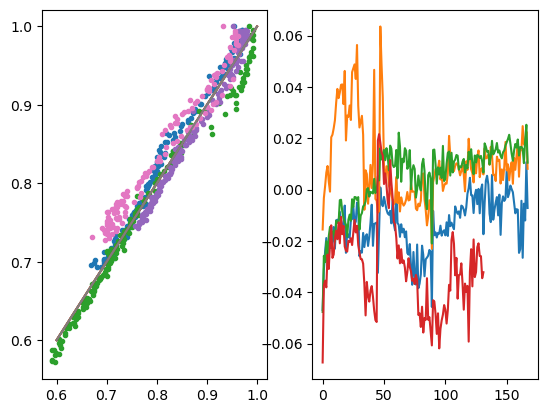

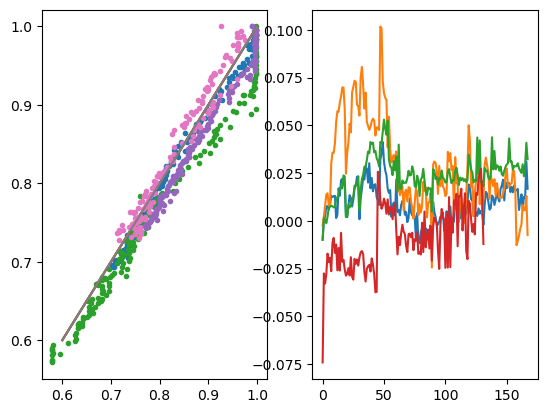

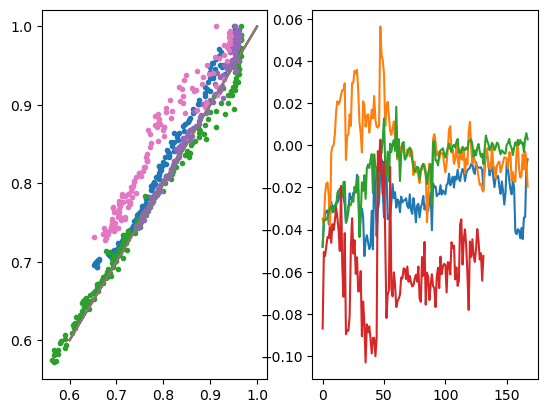

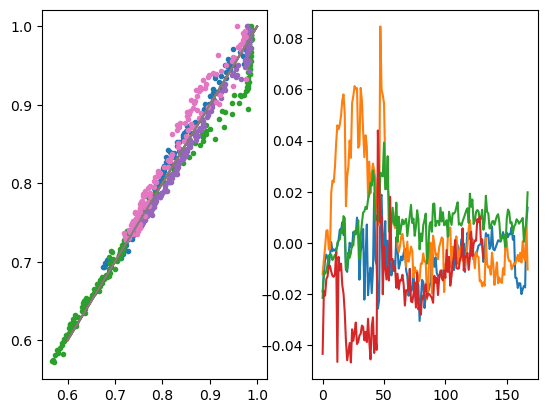

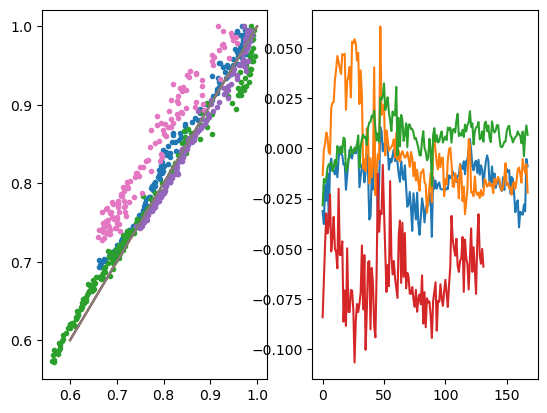

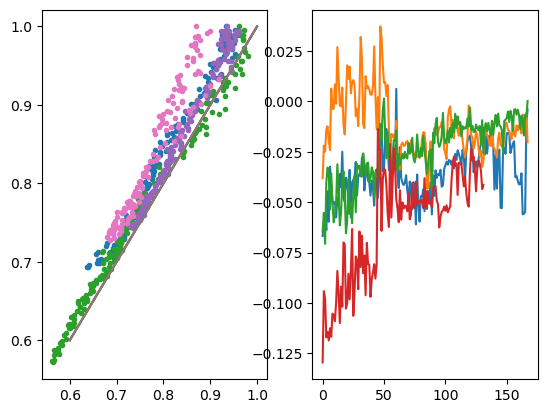

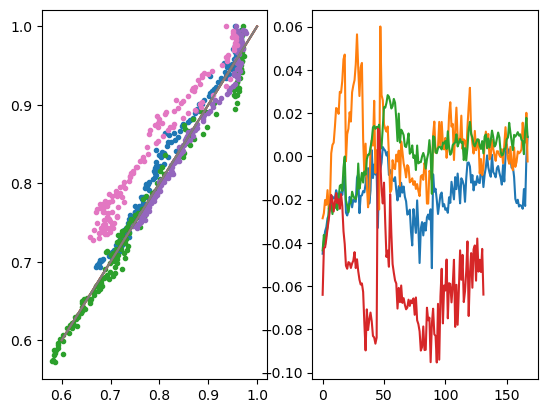

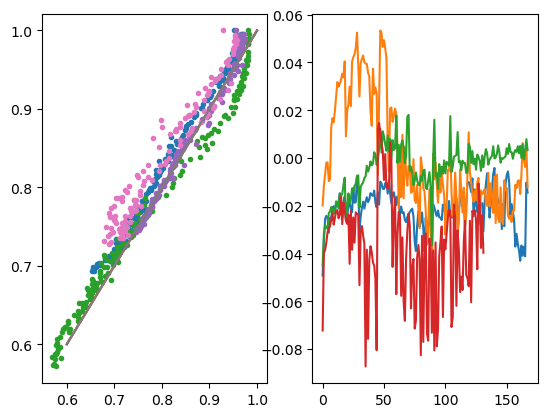

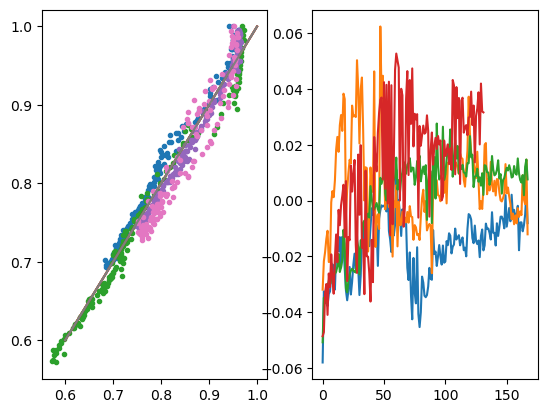

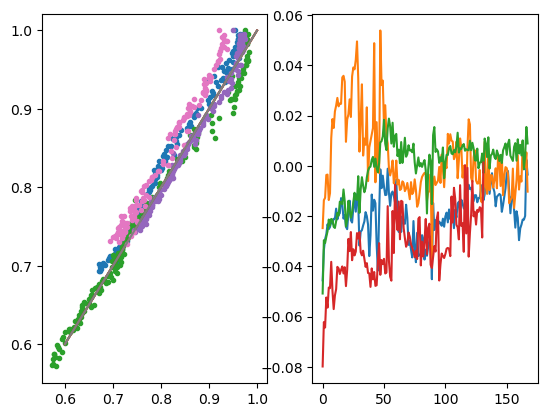

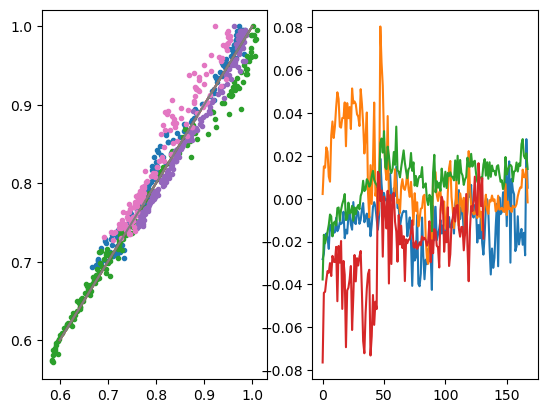

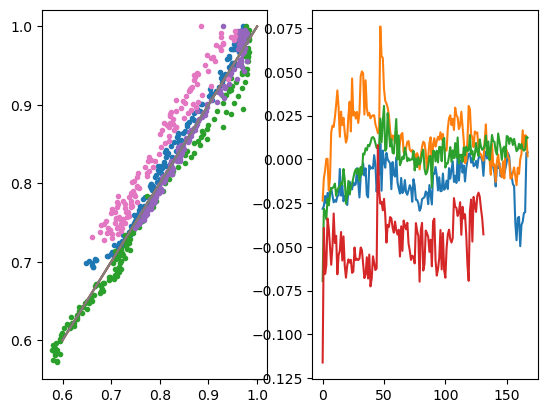

In [13]:
loopNum = 30
#CNN-ATT-POSITION
rmse = [[] for _ in range(loopNum)]
mae = [[] for _ in range(loopNum)]
model_states = [[] for _ in range(loopNum)]
print("CNN-LSTM")
#model_t = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)

for i in range(loopNum):
    model = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
    _, rmse[i],mae[i],model_states[i]=trainLoop(train_loader,test_loader,model,0)
    print(f"{i+1} / {loopNum} ")
    model_t = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
    results = testRestult(model_t, model_states[i], mat)
print(f"lowest RMSE: {np.min(rmse)}\n lowest MAE: {np.min(mae)}\n mean RMSE: {np.mean(rmse)}")

# idx = np.argmin(rmse)
# print(idx)
# model = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
#results = testRestult(model, model_states[4], mat)
#scipy.io.savemat('result.mat', results)

0.012645324692130089 0.010090436786413193
0.022052636370062828 0.01380091905593872
0.018813541159033775 0.016370238736271858
0.04596669226884842 0.04050659015774727


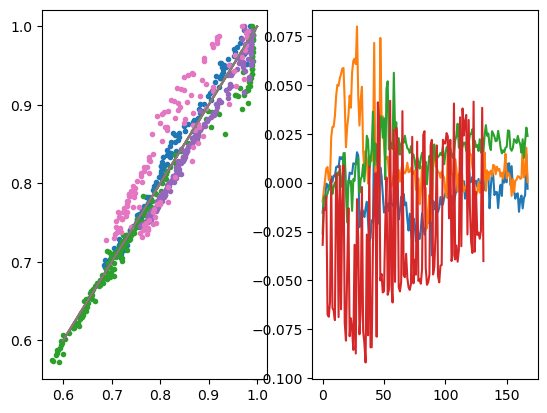

In [14]:
model = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
results = testRestult(model, model_states[0], mat)
scipy.io.savemat('result.mat', results)

In [15]:
# from torchview import draw_graph
# numChannels = XTrain[0].size(0)
# numHeads = 4
# numHiddenUnits = 128
# num_epochs = 200
# batch_size = 2
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN_LSTM_position_skip(numChannels, numHeads, numHiddenUnits).to(device)
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(15,3,50), device='cuda')
# model_graph.visual_graph